In [1]:
import wfdb
import pandas as pd

def convert_beats_to_csv(record_name, output_csv):
    """
    Convert .hea, .atr, and .dat files to a .csv file with Time, signals, Annotation, and R-R Interval.

    Parameters:
    - record_name: Base name of the record (without extension).
    - output_csv: Path to save the output CSV file.
    """
    try:
        # Load the record and annotation
        record = wfdb.rdrecord(record_name)
        annotation = wfdb.rdann(record_name, 'atr')

        # Extract sampling frequency
        fs = record.fs

        # Identify available signals
        signal_names = record.sig_name
        print(f"Available signals in the record: {signal_names}")  # Debug statement

        # Define a priority list for required signals
        priority_signals = ["MLII", "II", "V5", "V4", "V2","V1"]

        # Select the first two available signals from the priority list
        selected_signals = [sig for sig in priority_signals if sig in signal_names][:2]
        if len(selected_signals) < 2:
            raise ValueError(f"Not enough signals found. Available signals: {signal_names}")

        # Extract signal indices and values
        signal_indices = {sig: signal_names.index(sig) for sig in selected_signals}
        signals = {sig: record.p_signal[:, idx] for sig, idx in signal_indices.items()}

        # Create a DataFrame for annotations
        annotations = pd.DataFrame({
            "Sample": annotation.sample,
            "Annotation": annotation.symbol
        })

        # Convert annotations to human-readable labels
        annotation_mapping = {
            "N": "Normal",  # Normal beat
            "V": "PVC",     # Premature ventricular contraction
            "A": "Atrial premature contraction",
            "L": "Left bundle branch block",
            "R": "Right bundle branch block",
            # Add other mappings if necessary
        }
        annotations["Annotation"] = annotations["Annotation"].map(annotation_mapping).fillna("Other")

        # Compute time values for each annotation sample
        annotations["Time"] = annotations["Sample"] / fs

        # Compute R-R Intervals (time difference between consecutive beats)
        annotations["R-R Interval"] = annotations["Time"].diff().fillna(0)

        # Extract signal values at annotation points
        for sig in selected_signals:
            annotations[sig] = annotations["Sample"].apply(lambda x: signals[sig][x])

        # Save the DataFrame to CSV
        annotations.to_csv(output_csv, index=False)

        # Display the summary of beats
        beat_counts = annotations["Annotation"].value_counts()
        print("Summary of beats:")
        print(beat_counts)
        print(f"Total beats: {len(annotations)}")

        # Print the first few rows of the CSV
        print("First few rows of the dataset:")
        print(annotations.head())

    except Exception as e:
        print(f"Error: {e}")

# Example usage
record_name = "210"  # Replace with the record's base name
output_csv = "210.csv"  # Output CSV file name
convert_beats_to_csv(record_name, output_csv)


Available signals in the record: ['MLII', 'V1']
Summary of beats:
Annotation
Normal    2423
PVC        194
Other       68
Name: count, dtype: int64
Total beats: 2685
First few rows of the dataset:
   Sample Annotation      Time  R-R Interval   MLII     V1
0      13      Other  0.036111      0.000000 -0.055  0.120
1      57     Normal  0.158333      0.122222  1.080 -0.275
2     250     Normal  0.694444      0.536111  1.035 -0.275
3     471     Normal  1.308333      0.613889  0.960 -0.265
4     625        PVC  1.736111      0.427778 -0.935  0.440


Preprocessing data...
Splitting data...
Building and training CNN model...
Epoch 1/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 333ms/step - accuracy: 0.5743 - loss: 4.7964 - val_accuracy: 0.9910 - val_loss: 2.1816
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 301ms/step - accuracy: 0.8152 - loss: 1.8305 - val_accuracy: 1.0000 - val_loss: 0.8690
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 280ms/step - accuracy: 0.8957 - loss: 1.0943 - val_accuracy: 1.0000 - val_loss: 1.0132
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 280ms/step - accuracy: 0.9121 - loss: 1.4173 - val_accuracy: 1.0000 - val_loss: 1.3896
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 276ms/step - accuracy: 0.9508 - loss: 1.3546 - val_accuracy: 1.0000 - val_loss: 1.1381
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 281ms/step - accuracy: 0.9703 - loss: 1.0645 - val_accuracy: 1.0000 - val_loss: 0.9964
Epoch 7/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 398ms/step - accuracy: 0.9745 - loss: 0.8655 - val_accuracy: 0.9873 - val_loss: 0.8371
Epoch 8/30
35/35 ━━━━━

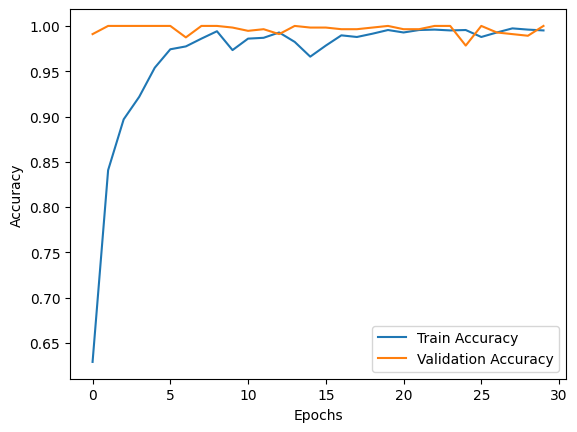

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step
Sensitivity: 1.00
Specificity: 1.00
PPV: 1.00
NPV: 1.00
FPR: 0.00
FNR: 0.00
FDR: 0.00
F1 Score: 1.00


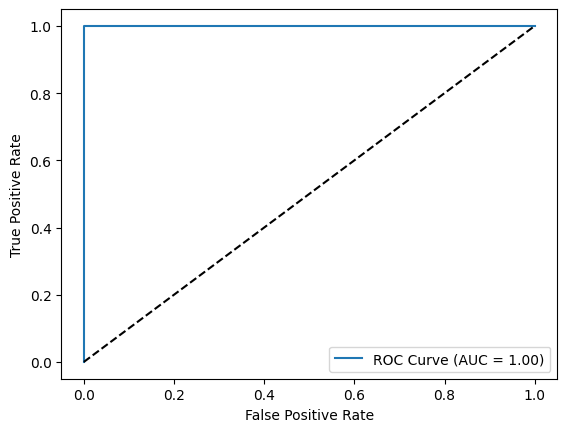

Visualizing 30-second ECG signal with PVCs highlighted...


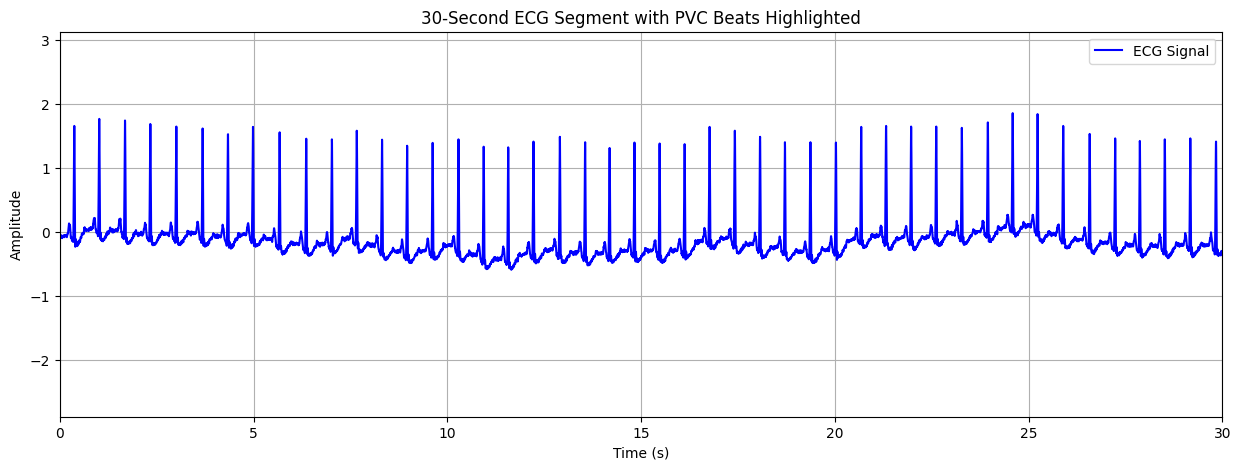

In [2]:
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import wfdb

# Helper function to extract combined features (Wavelet, Hilbert, WVD)
def extract_combined_features(signal):
    return np.concatenate([
        signal,  # Original signal (placeholder)
        np.abs(np.fft.fft(signal)),  # FFT magnitude as placeholder
    ])

# Preprocess ECG data
def preprocess_data_with_combined_features(record_name, priority_signals, window_size=256):
    record = wfdb.rdrecord(record_name)
    annotation = wfdb.rdann(record_name, 'atr')
    signal_names = record.sig_name
    available_signals = [sig for sig in priority_signals if sig in signal_names][:1]

    if len(available_signals) < 1:
        raise ValueError("No matching signals found in the priority list.")

    signals = {sig: record.p_signal[:, signal_names.index(sig)] for sig in available_signals}
    features, labels = [], []

    for i, sample in enumerate(annotation.sample):
        start = max(0, sample - window_size // 2)
        end = min(len(record.p_signal), sample + window_size // 2)

        signal_window = signals[available_signals[0]][start:end]
        if len(signal_window) < window_size:
            signal_window = np.pad(signal_window, (0, window_size - len(signal_window)), 'constant')

        combined_features = extract_combined_features(signal_window)
        features.append(combined_features)
        labels.append(1 if annotation.symbol[i] == 'V' else 0)

    scaler = StandardScaler()
    features = scaler.fit_transform(features)

    return np.array(features), np.array(labels), annotation, signals[available_signals[0]]

# Build optimized CNN model
def build_optimized_cnn_model(input_shape):
    inputs = Input(shape=input_shape)

    # CNN layers
    x = Reshape((input_shape[0], 1))(inputs)
    x = Conv1D(64, kernel_size=3, activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(128, kernel_size=5, activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)

    # Dense layers
    x = Flatten()(x)
    x = Dense(256, activation='relu', kernel_regularizer='l2')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Plot waveform representation with PVC highlights
def plot_signal_with_pvc(signal, annotations, sample_rate, window_length=30):
    plt.figure(figsize=(15, 5))
    time = np.linspace(0, len(signal) / sample_rate, len(signal))

    # Identify PVC beats within the selected window
    pvc_indices = [i for i, sym in enumerate(annotations.symbol) if sym == 'V']
    pvc_samples = [annotations.sample[i] for i in pvc_indices]

    # Plot the signal
    plt.plot(time, signal, label="ECG Signal", color='blue')

    # Highlight PVC locations
    for pvc_sample in pvc_samples:
        pvc_time = pvc_sample / sample_rate
        if pvc_time <= window_length:  # Highlight PVCs within the first 30 seconds
            plt.axvline(pvc_time, color='red', linestyle='--', label="PVC" if pvc_sample == pvc_samples[0] else "")

    plt.xlim(0, window_length)
    plt.title(f"30-Second ECG Segment with PVC Beats Highlighted")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.show()

# Calculate additional metrics
def calculate_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    ppv = tp / (tp + fp)  # Positive Predictive Value
    npv = tn / (tn + fn)  # Negative Predictive Value
    fpr = fp / (fp + tn)  # False Positive Rate
    fnr = fn / (tp + fn)  # False Negative Rate
    fdr = fp / (tp + fp)  # False Discovery Rate
    f1_score = 2 * tp / (2 * tp + fp + fn)
    return sensitivity, specificity, ppv, npv, fpr, fnr, fdr, f1_score

# Main function
def main(record_name, priority_signals, output_csv="output.csv"):
    print("Preprocessing data...")
    features, labels, annotations, signal = preprocess_data_with_combined_features(record_name, priority_signals)

    print("Splitting data...")
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
    class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

    print("Building and training CNN model...")
    model = build_optimized_cnn_model(input_shape=X_train.shape[1:])
    history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test),
                        class_weight=class_weights_dict)

    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {test_accuracy:.2f}")

    # Plot training and validation accuracy
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Predict and calculate metrics
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)

    sensitivity, specificity, ppv, npv, fpr, fnr, fdr, f1_score = calculate_metrics(y_true, y_pred)

    print(f"Sensitivity: {sensitivity:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"PPV: {ppv:.2f}")
    print(f"NPV: {npv:.2f}")
    print(f"FPR: {fpr:.2f}")
    print(f"FNR: {fnr:.2f}")
    print(f"FDR: {fdr:.2f}")
    print(f"F1 Score: {f1_score:.2f}")

    # Generate ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

    # Visualize waveform representation after training
    print("Visualizing 30-second ECG signal with PVCs highlighted...")
    plot_signal_with_pvc(signal, annotations, sample_rate=wfdb.rdrecord(record_name).fs, window_length=30)

# Example usage
record_name = "234"  # Replace with your record name
priority_signals = ["MLII", "II", "V5", "V4", "V2", "V1"]
main(record_name, priority_signals)


Preprocessing data...
Splitting data...
Building and training CNN model...
Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.8928 - loss: 10.4310 - val_accuracy: 0.8339 - val_loss: 6.4337
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.9802 - loss: 4.7858 - val_accuracy: 0.3553 - val_loss: 4.8230
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.9806 - loss: 2.1808 - val_accuracy: 0.3536 - val_loss: 4.1975
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.9825 - loss: 1.2787 - val_accuracy: 0.3586 - val_loss: 3.4816
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.9825 - loss: 1.0083 - val_accuracy: 0.4227 - val_loss: 1.6474
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - accuracy: 0.9907 - loss: 0.6310 - val_accuracy: 0.9128 - val_loss: 0.8594
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 168s 3s/step - accuracy: 0.9865 - loss: 0.5796 - val_accuracy: 0.9688 - val_loss: 0.5482
Epoch 8/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 113

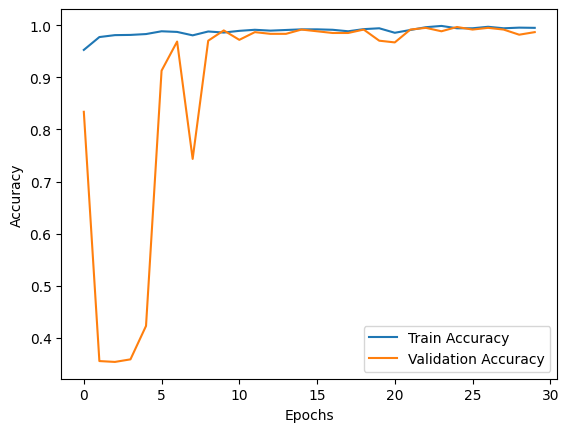

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step
Sensitivity: 1.00
Specificity: 0.98
PPV: 0.96
NPV: 1.00
FPR: 0.02
FNR: 0.00
FDR: 0.04
F1 Score: 0.98


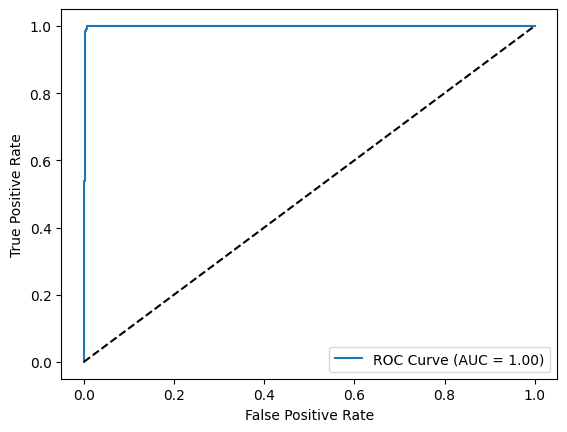

Number of PVC beats detected in the dataset: 223
Visualizing 30-second ECG signal with PVCs highlighted...


C:\Python 3.12\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


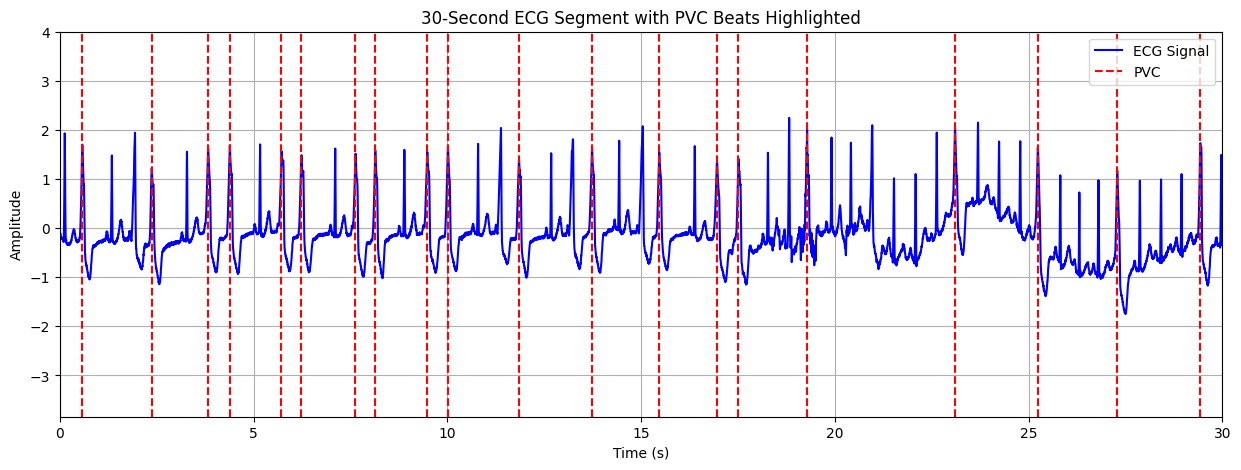

Visualizing 30-second ECG signal with detected PVCs highlighted...


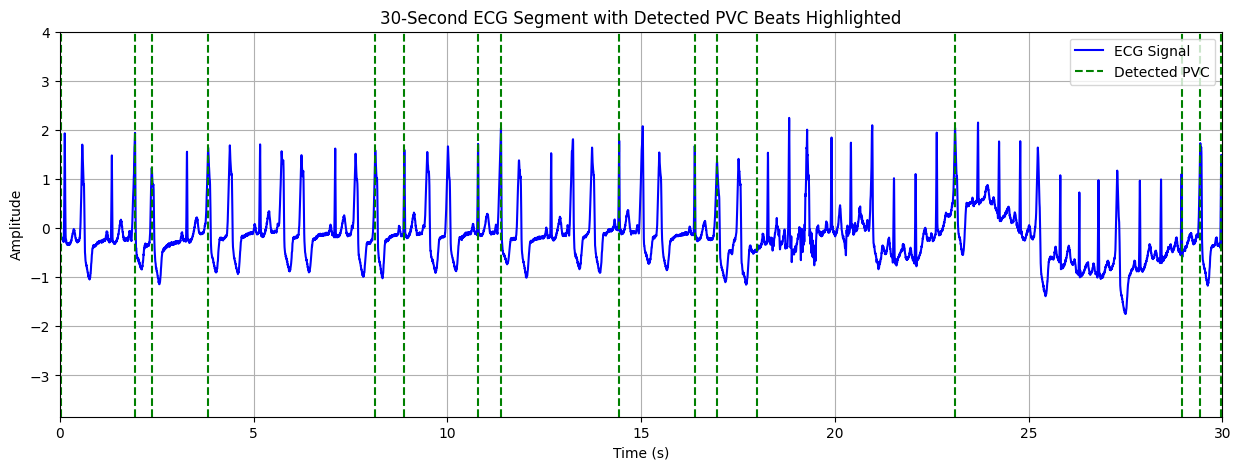

In [8]:
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import wfdb
import pywt
from scipy.signal import hilbert

# Helper function to extract combined features (Wavelet, Hilbert, WVD)
def extract_combined_features(signal):
    # Wavelet Transform
    coeffs, _ = pywt.cwt(signal, scales=np.arange(1, 128), wavelet='morl')
    wavelet_features = np.abs(coeffs).mean(axis=0)

    # Hilbert Transform
    analytic_signal = hilbert(signal)
    amplitude_envelope = np.abs(analytic_signal)

    # FFT magnitude
    fft_magnitude = np.abs(np.fft.fft(signal))

    return np.concatenate([
        signal,  # Original signal
        wavelet_features,  # Wavelet features
        amplitude_envelope,  # Hilbert features
        fft_magnitude  # FFT magnitude
    ])

# Preprocess ECG data
def preprocess_data_with_combined_features(record_name, priority_signals, window_size=256):
    record = wfdb.rdrecord(record_name)
    annotation = wfdb.rdann(record_name, 'atr')
    signal_names = record.sig_name
    available_signals = [sig for sig in priority_signals if sig in signal_names][:1]

    if len(available_signals) < 1:
        raise ValueError("No matching signals found in the priority list.")

    signals = {sig: record.p_signal[:, signal_names.index(sig)] for sig in available_signals}
    features, labels = [], []

    for i, sample in enumerate(annotation.sample):
        start = max(0, sample - window_size // 2)
        end = min(len(record.p_signal), sample + window_size // 2)

        signal_window = signals[available_signals[0]][start:end]
        if len(signal_window) < window_size:
            signal_window = np.pad(signal_window, (0, window_size - len(signal_window)), 'constant')

        combined_features = extract_combined_features(signal_window)
        features.append(combined_features)
        labels.append(1 if annotation.symbol[i] == 'V' else 0)

    scaler = StandardScaler()
    features = scaler.fit_transform(features)

    return np.array(features), np.array(labels), annotation, signals[available_signals[0]]

# Build optimized CNN model
def build_optimized_cnn_model(input_shape):
    inputs = Input(shape=input_shape)

    # CNN layers
    x = Reshape((input_shape[0], 1))(inputs)
    x = Conv1D(64, kernel_size=3, activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(128, kernel_size=5, activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(256, kernel_size=7, activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)

    # Dense layers
    x = Flatten()(x)
    x = Dense(512, activation='relu', kernel_regularizer='l2')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Plot waveform representation with PVC highlights
def plot_signal_with_pvc(signal, annotations, sample_rate, window_length=30):
    plt.figure(figsize=(15, 5))
    time = np.linspace(0, len(signal) / sample_rate, len(signal))

    # Identify PVC beats within the selected window
    pvc_indices = [i for i, sym in enumerate(annotations.symbol) if sym == 'V']
    pvc_samples = [annotations.sample[i] for i in pvc_indices]

    # Plot the signal
    plt.plot(time, signal, label="ECG Signal", color='blue')

    # Highlight PVC locations
    for pvc_sample in pvc_samples:
        pvc_time = pvc_sample / sample_rate
        if pvc_time <= window_length:  # Highlight PVCs within the first 30 seconds
            plt.axvline(pvc_time, color='red', linestyle='--', label="PVC" if pvc_sample == pvc_samples[0] else "")

    plt.xlim(0, window_length)
    plt.title(f"30-Second ECG Segment with PVC Beats Highlighted")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualize detected PVC beats
def visualize_detected_pvc_beats(signal, annotations, sample_rate, y_pred, window_length=30):
    plt.figure(figsize=(15, 5))
    time = np.linspace(0, len(signal) / sample_rate, len(signal))

    # Identify detected PVC beats within the selected window
    detected_pvc_indices = np.where(y_pred == 1)[0]
    detected_pvc_samples = [annotations.sample[i] for i in detected_pvc_indices]

    # Plot the signal
    plt.plot(time, signal, label="ECG Signal", color='blue')

    # Highlight detected PVC locations
    for pvc_sample in detected_pvc_samples:
        pvc_time = pvc_sample / sample_rate
        if pvc_time <= window_length:  # Highlight PVCs within the first 30 seconds
            plt.axvline(pvc_time, color='green', linestyle='--', label="Detected PVC" if pvc_sample == detected_pvc_samples[0] else "")

    plt.xlim(0, window_length)
    plt.title(f"30-Second ECG Segment with Detected PVC Beats Highlighted")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.show()

# Calculate additional metrics
def calculate_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    ppv = tp / (tp + fp)  # Positive Predictive Value
    npv = tn / (tn + fn)  # Negative Predictive Value
    fpr = fp / (fp + tn)  # False Positive Rate
    fnr = fn / (tp + fn)  # False Negative Rate
    fdr = fp / (tp + fp)  # False Discovery Rate
    f1_score = 2 * tp / (2 * tp + fp + fn)
    return sensitivity, specificity, ppv, npv, fpr, fnr, fdr, f1_score

# Main function
def main(record_name, priority_signals, output_csv="output.csv"):
    print("Preprocessing data...")
    features, labels, annotations, signal = preprocess_data_with_combined_features(record_name, priority_signals)

    print("Splitting data...")
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
    class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

    print("Building and training CNN model...")
    model = build_optimized_cnn_model(input_shape=X_train.shape[1:])
    history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test),
                        class_weight=class_weights_dict)

    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {test_accuracy:.2f}")

    # Plot training and validation accuracy
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Predict and calculate metrics
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)

    sensitivity, specificity, ppv, npv, fpr, fnr, fdr, f1_score = calculate_metrics(y_true, y_pred)

    print(f"Sensitivity: {sensitivity:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"PPV: {ppv:.2f}")
    print(f"NPV: {npv:.2f}")
    print(f"FPR: {fpr:.2f}")
    print(f"FNR: {fnr:.2f}")
    print(f"FDR: {fdr:.2f}")
    print(f"F1 Score: {f1_score:.2f}")

    # Generate ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

    # Count the number of detected PVC beats
    detected_pvc_count = np.sum(y_pred == 1)
    print(f"Number of PVC beats detected in the dataset: {detected_pvc_count}")

    # Visualize waveform representation after training
    print("Visualizing 30-second ECG signal with PVCs highlighted...")
    plot_signal_with_pvc(signal, annotations, sample_rate=wfdb.rdrecord(record_name).fs, window_length=30)

    # Visualize detected PVC beats
    print("Visualizing 30-second ECG signal with detected PVCs highlighted...")
    visualize_detected_pvc_beats(signal, annotations, sample_rate=wfdb.rdrecord(record_name).fs, y_pred=y_pred, window_length=30)

# Example usage
record_name = "208"  # Replace with your record name
priority_signals = ["MLII", "II", "V5", "V4", "V2", "V1"]
main(record_name, priority_signals)


Preprocessing data...
Splitting data...
Building and training CNN-LSTM model...
Epoch 1/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.7510 - loss: 1.5015 - val_accuracy: 0.9348 - val_loss: 1.2818
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 26s 776ms/step - accuracy: 0.7976 - loss: 1.2113 - val_accuracy: 0.9385 - val_loss: 1.0415
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 27s 782ms/step - accuracy: 0.8798 - loss: 0.9828 - val_accuracy: 0.9385 - val_loss: 0.8735
Epoch 4/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 41s 767ms/step - accuracy: 0.9071 - loss: 0.7979 - val_accuracy: 0.9385 - val_loss: 0.7541
Epoch 5/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 26s 769ms/step - accuracy: 0.9346 - loss: 0.6608 - val_accuracy: 0.9385 - val_loss: 0.6793
Epoch 6/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 26s 772ms/step - accuracy: 0.9241 - loss: 0.6090 - val_accuracy: 0.9385 - val_loss: 0.6147
Epoch 7/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 26s 777ms/step - accuracy: 0.9601 - loss: 0.4863 - val_accuracy: 0.9385 - val_loss: 0.5639
Epoch 8/30
34/34 ━━━

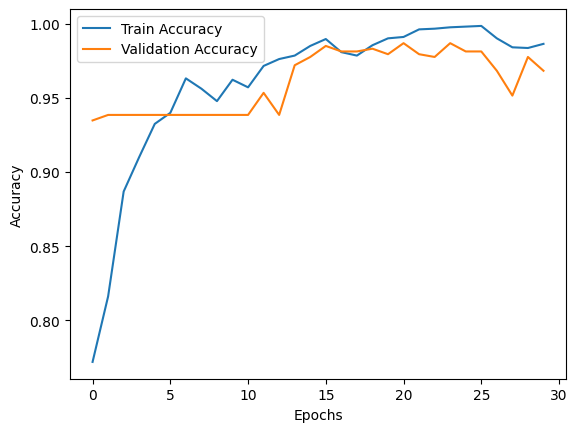

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 186ms/step
Sensitivity: 0.91
Specificity: 0.97
PPV: 0.68
NPV: 0.99
FPR: 0.03
FNR: 0.09
FDR: 0.32
F1 Score: 0.78


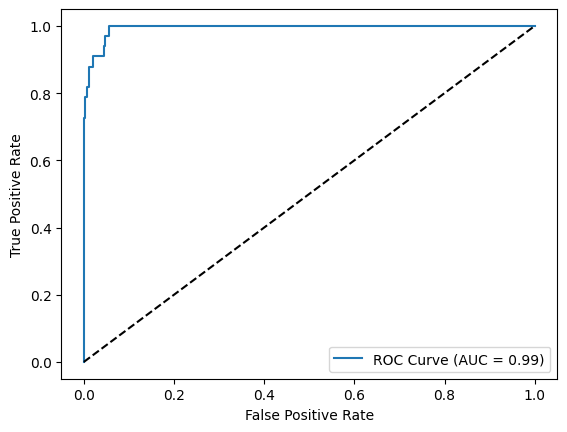

Number of PVC beats detected in the dataset: 44
Visualizing 30-second ECG signal with PVCs highlighted...


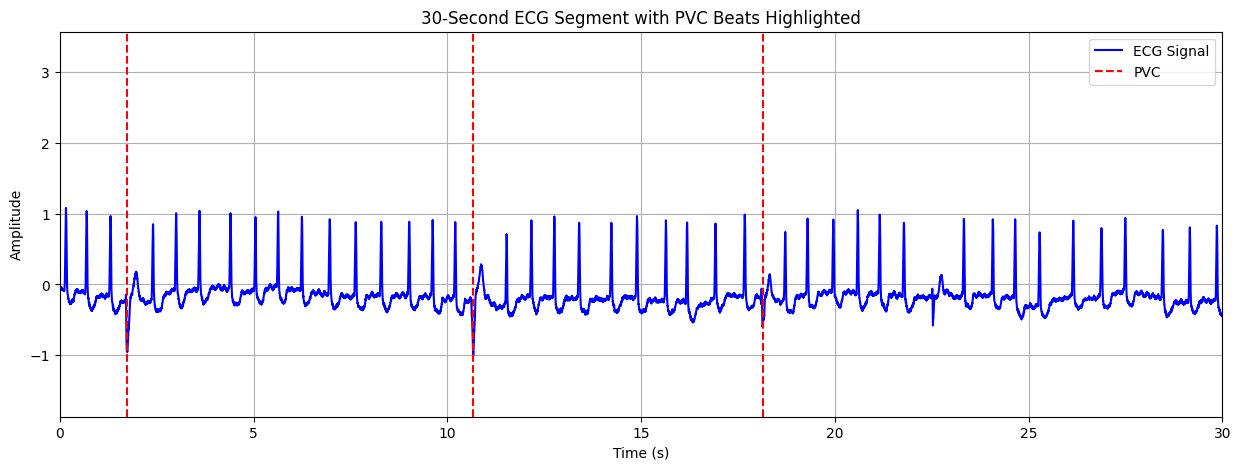

Visualizing 30-second ECG signal with detected PVCs highlighted...


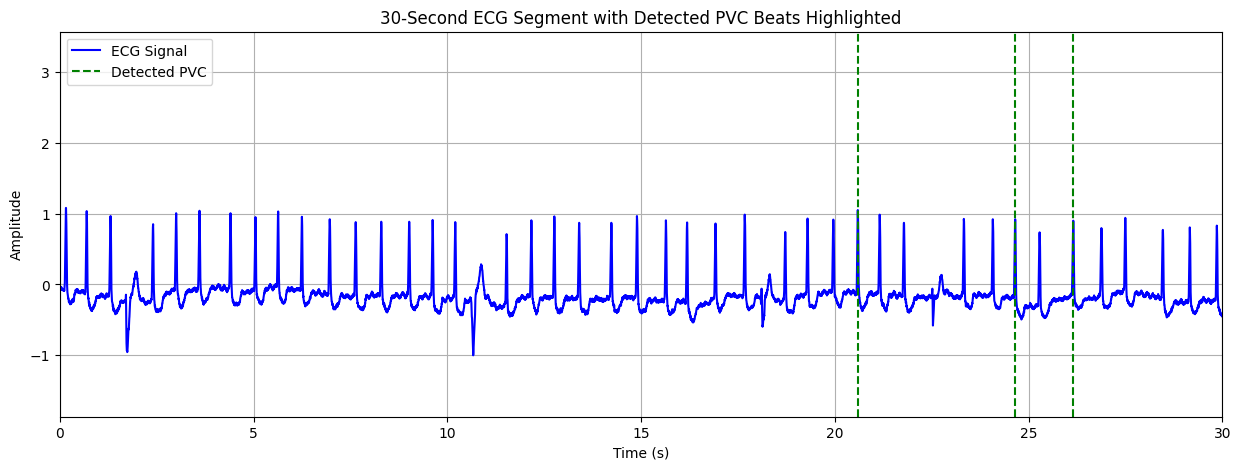

In [1]:
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, Reshape, LSTM, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import wfdb

# Helper function to extract combined features (Wavelet, Hilbert, WVD)
def extract_combined_features(signal):
    # Placeholder for combined feature extraction (implement this method as per your needs)
    return np.concatenate([
        signal,  # Original signal (placeholder)
        np.abs(np.fft.fft(signal)),  # FFT magnitude as placeholder
    ])

# Preprocess ECG data
def preprocess_data_with_combined_features(record_name, priority_signals, window_size=256):
    record = wfdb.rdrecord(record_name)
    annotation = wfdb.rdann(record_name, 'atr')
    signal_names = record.sig_name
    available_signals = [sig for sig in priority_signals if sig in signal_names][:1]

    if len(available_signals) < 1:
        raise ValueError("No matching signals found in the priority list.")

    signals = {sig: record.p_signal[:, signal_names.index(sig)] for sig in available_signals}
    features, labels = [], []

    for i, sample in enumerate(annotation.sample):
        start = max(0, sample - window_size // 2)
        end = min(len(record.p_signal), sample + window_size // 2)

        signal_window = signals[available_signals[0]][start:end]
        if len(signal_window) < window_size:
            signal_window = np.pad(signal_window, (0, window_size - len(signal_window)), 'constant')

        combined_features = extract_combined_features(signal_window)
        features.append(combined_features)
        labels.append(1 if annotation.symbol[i] == 'V' else 0)

    scaler = StandardScaler()
    features = scaler.fit_transform(features)

    return np.array(features), np.array(labels), annotation, signals[available_signals[0]]

# Build optimized CNN-LSTM model
def build_optimized_cnn_lstm_model(input_shape):
    inputs = Input(shape=input_shape)

    # CNN layers
    x = Reshape((input_shape[0], 1))(inputs)
    x = Conv1D(64, kernel_size=3, activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(128, kernel_size=5, activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)

    # LSTM layers with attention
    lstm_out = LSTM(128, return_sequences=True)(x)
    attention = Attention()([lstm_out, lstm_out])
    lstm_out = LSTM(64, return_sequences=False)(attention)

    # Dense layers
    x = Dense(256, activation='relu', kernel_regularizer='l2')(lstm_out)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Plot waveform representation with PVC highlights
def plot_signal_with_pvc(signal, annotations, sample_rate, window_length=30):
    plt.figure(figsize=(15, 5))
    time = np.linspace(0, len(signal) / sample_rate, len(signal))

    # Identify PVC beats within the selected window
    pvc_indices = [i for i, sym in enumerate(annotations.symbol) if sym == 'V']
    pvc_samples = [annotations.sample[i] for i in pvc_indices]

    # Plot the signal
    plt.plot(time, signal, label="ECG Signal", color='blue')

    # Highlight PVC locations
    for pvc_sample in pvc_samples:
        pvc_time = pvc_sample / sample_rate
        if pvc_time <= window_length:  # Highlight PVCs within the first 30 seconds
            plt.axvline(pvc_time, color='red', linestyle='--', label="PVC" if pvc_sample == pvc_samples[0] else "")

    plt.xlim(0, window_length)
    plt.title(f"30-Second ECG Segment with PVC Beats Highlighted")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualize detected PVC beats
def visualize_detected_pvc_beats(signal, annotations, sample_rate, y_pred, window_length=30):
    plt.figure(figsize=(15, 5))
    time = np.linspace(0, len(signal) / sample_rate, len(signal))

    # Identify detected PVC beats within the selected window
    detected_pvc_indices = np.where(y_pred == 1)[0]
    detected_pvc_samples = [annotations.sample[i] for i in detected_pvc_indices]

    # Plot the signal
    plt.plot(time, signal, label="ECG Signal", color='blue')

    # Highlight detected PVC locations
    for pvc_sample in detected_pvc_samples:
        pvc_time = pvc_sample / sample_rate
        if pvc_time <= window_length:  # Highlight PVCs within the first 30 seconds
            plt.axvline(pvc_time, color='green', linestyle='--', label="Detected PVC" if pvc_sample == detected_pvc_samples[0] else "")

    plt.xlim(0, window_length)
    plt.title(f"30-Second ECG Segment with Detected PVC Beats Highlighted")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.show()

# Calculate additional metrics
def calculate_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    ppv = tp / (tp + fp)  # Positive Predictive Value
    npv = tn / (tn + fn)  # Negative Predictive Value
    fpr = fp / (fp + tn)  # False Positive Rate
    fnr = fn / (tp + fn)  # False Negative Rate
    fdr = fp / (tp + fp)  # False Discovery Rate
    f1_score = 2 * tp / (2 * tp + fp + fn)
    return sensitivity, specificity, ppv, npv, fpr, fnr, fdr, f1_score

# Main function
def main(record_name, priority_signals, output_csv="output.csv"):
    print("Preprocessing data...")
    features, labels, annotations, signal = preprocess_data_with_combined_features(record_name, priority_signals)

    print("Splitting data...")
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
    class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

    print("Building and training CNN-LSTM model...")
    model = build_optimized_cnn_lstm_model(input_shape=X_train.shape[1:])
    history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test),
                        class_weight=class_weights_dict)

    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {test_accuracy:.2f}")

    # Plot training and validation accuracy
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Predict and calculate metrics
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)

    sensitivity, specificity, ppv, npv, fpr, fnr, fdr, f1_score = calculate_metrics(y_true, y_pred)

    print(f"Sensitivity: {sensitivity:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"PPV: {ppv:.2f}")
    print(f"NPV: {npv:.2f}")
    print(f"FPR: {fpr:.2f}")
    print(f"FNR: {fnr:.2f}")
    print(f"FDR: {fdr:.2f}")
    print(f"F1 Score: {f1_score:.2f}")

    # Generate ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

    # Count the number of detected PVC beats
    detected_pvc_count = np.sum(y_pred == 1)
    print(f"Number of PVC beats detected in the dataset: {detected_pvc_count}")

    # Visualize waveform representation after training
    print("Visualizing 30-second ECG signal with PVCs highlighted...")
    plot_signal_with_pvc(signal, annotations, sample_rate=wfdb.rdrecord(record_name).fs, window_length=30)

    # Visualize detected PVC beats
    print("Visualizing 30-second ECG signal with detected PVCs highlighted...")
    visualize_detected_pvc_beats(signal, annotations, sample_rate=wfdb.rdrecord(record_name).fs, y_pred=y_pred, window_length=30)

# Example usage
record_name = "210"  # Replace with your record name
priority_signals = ["MLII", "II", "V5", "V4", "V2", "V1"]
main(record_name, priority_signals)
